In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Ex 4.1

In [2]:
del_x = 1080/2
del_y = 1920/2
f = 1000
K = np.array([ [f, 0, del_x], [0, f, del_y], [0, 0, 1]])
R = np.array([ [np.sqrt(1/2), -np.sqrt(1/2), 0], [np.sqrt(1/2), np.sqrt(1/2), 0], [0, 0, 1]])
t = np.array([ [0], [0], [10]])
Q = []

for x in range(2):
    for y in range(2):
        for z in range(2):
            Q.append([x,y,z])

Q = np.array(Q)
Q_H = np.hstack((Q, np.ones((len(Q), 1))))
P = K @ np.hstack((R,t))
print('P:\n', P)
p = (K @ np.hstack((R,t)) @ Q_H.T)
p = p[:-1]/p[-1]
print('Projection Ponits:\n', p.T)

P:
 [[ 7.07106781e+02 -7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 7.07106781e+02  7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]
Projection Ponits:
 [[ 540.          960.        ]
 [ 540.          960.        ]
 [ 469.28932188 1030.71067812]
 [ 475.71756535 1024.28243465]
 [ 610.71067812 1030.71067812]
 [ 604.28243465 1024.28243465]
 [ 540.         1101.42135624]
 [ 540.         1088.56486931]]


# Ex 4.2

In [3]:
def CrossOp(p):
    CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')
    return CP_matrix

def DLT_GetProjMat(proj, Q):
    B = []
    for i, j in zip(proj, Q):
        b = np.kron(j, CrossOp(i))
        B.append(b)
    B = np.array(B).reshape(-1,12)
    U, S, V = np.linalg.svd(B)
    Proj_Mat = V[-1,:].reshape(-1,3).T
    return Proj_Mat

def normalize3d(p):
    '''
    Normalize = (x-mean)/std
    '''
    X = p[:,0]
    Y = p[:,1]
    Z = p[:,2]
    T = np.array([ [1/X.std(), 0, 0, -X.mean()/X.std()], [0, 1/Y.std(), 0, -Y.mean()/Y.std()], [0, 0, 1/Z.std(), -Z.mean()/Z.std()], [0, 0, 0, 1] ])
    q = T @ p
    return T, q

def normalize2d(p):
    '''
    Normalize = (x-mean)/std
    '''
    X = p[:,0]
    Y = p[:,1]
    T = np.array([ [1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
    q = T @ p
    return T, q

In [4]:
## Without Normalization
p_Hom = np.hstack((p.T, np.ones(((p.T).shape[0],1))))
Q_H = np.hstack((Q, np.ones((len(Q), 1))))
proj_Mat = DLT_GetProjMat(p_Hom, Q_H)
print('Estimated Project Matrix:\n', proj_Mat)
#Q_H = np.hstack((Q, np.ones((len(Q), 1))))
p_new = (proj_Mat @ Q_H.T)
p_new = (p_new[:-1]/p_new[-1]).T
print('Re-projection points:\n', p_new)

sum = 0
for i, j in zip(p_new, p.T):
    sum = sum + ( np.linalg.norm((i-j)) ** 2 ) 
error = np.sqrt(sum)
print('error:\n', error)

Estimated Project Matrix:
 [[ 6.33628381e-02 -6.33671610e-02  4.83893975e-02  4.83895086e-01]
 [ 6.33620844e-02  6.33570873e-02  8.60256419e-02  8.60257909e-01]
 [-1.56380553e-09 -6.41152793e-09  8.96100233e-05  8.96101837e-04]]
Re-projection points:
 [[ 540.00010514  960.00016232]
 [ 540.00008034  960.00016743]
 [ 469.28922209 1030.71053601]
 [ 475.71749073 1024.28229398]
 [ 610.71058758 1030.7105366 ]
 [ 604.28233736 1024.28232613]
 [ 540.00008706 1101.42153963]
 [ 540.00006389 1088.56497279]]
error:
 0.0004825633766027056


In [5]:
## With Mormalization
Q_H = np.hstack((Q, np.ones((Q.shape[0], 1))))
p_H = np.hstack((p.T, np.ones((p.T.shape[0], 1))))
T_Q, Q_norm = normalize3d(Q_H.T)
T_proj, Proj_norm = normalize2d(p_H.T)

proj_Mat_norm = DLT_GetProjMat(Proj_norm.T, Q_norm.T)
proj_Mat = np.linalg.inv(T_proj) @ proj_Mat_norm @ T_Q
print('proj_Matrix:\n', proj_Mat)

p_new = (proj_Mat @ Q_H.T)
p_new = (p_new[:-1]/p_new[-1]).T
print('Re-projection points:\n', p_new)

sum = 0
for i, j in zip(p_new, p.T):
    sum = sum + ( np.linalg.norm((i-j)) ** 2 ) 
error = np.sqrt(sum)
print('error:\n', error)

proj_Matrix:
 [[ 4.08035200e+01 -4.08036367e+01  3.11606946e+01  3.11606964e+02]
 [ 4.08034546e+01  4.08034813e+01  5.53967779e+01  5.53967956e+02]
 [-1.21068758e-07 -9.51150163e-08  5.77049900e-02  5.77049935e-01]]
Re-projection points:
 [[ 539.99999957  960.00003188]
 [ 539.99999971  960.00000935]
 [ 469.28932161 1030.7106877 ]
 [ 475.71756581 1024.28242312]
 [ 610.71068071 1030.71068785]
 [ 604.28243624 1024.282423  ]
 [ 539.99999957 1101.42137016]
 [ 539.99999971 1088.56485866]]
error:
 4.331871453514734e-05


# Ex 4.3

In [6]:
def checkerboard_points(n,m):
    Q = []
    for i in range(n):
        for j in range(m):
            Q.append([i - (n-1)/2, j - (m-1)/2, 0])
    Q = np.array(Q).T.reshape(3,-1)
    return Q

In [7]:
Q = checkerboard_points(10,20)

# Ex 4.4

In [8]:
Ra = Rotation.from_euler('xyz', [math.pi/10, 0, 0]).as_matrix()
Qa = Ra @ Q

Rb = Rotation.from_euler('xyz', [0,0,0]).as_matrix()
Qb = Rb @ Q

Rc = Rotation.from_euler('xyz', [-math.pi/10,0,0]).as_matrix()
Qc = Rc @ Q

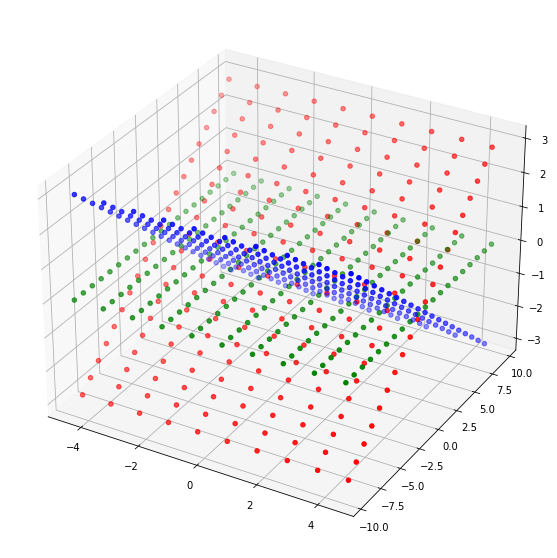

In [9]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(Qa[0], Qa[1], Qa[2], c='r')
ax.scatter(Qb[0], Qb[1], Qb[2], c='g')
ax.scatter(Qc[0], Qc[1], Qc[2], c='b')

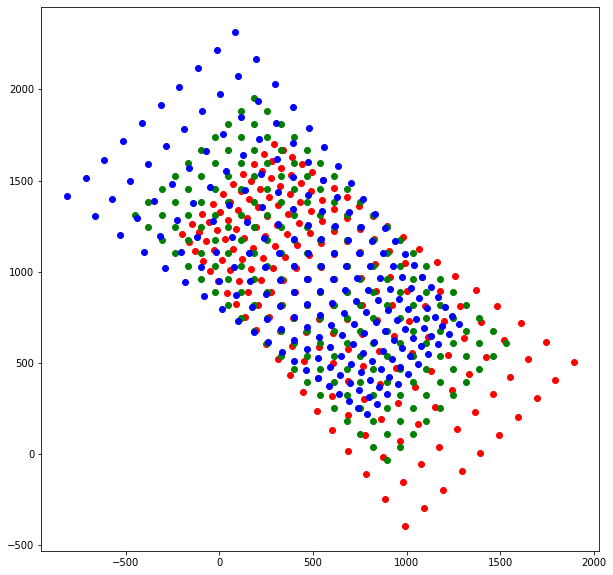

In [10]:
proj_mat = P
qa = proj_mat @ np.vstack((Qa, np.ones((1, Qa.shape[1]))))
qa = qa[:-1]/qa[-1]

qb = proj_mat @ np.vstack((Qb, np.ones((1, Qb.shape[1]))))
qb = qb[:-1]/qb[-1]

qc = proj_mat @ np.vstack((Qc, np.ones((1, Qc.shape[1]))))
qc = qc[:-1]/qc[-1]

plt.figure(figsize=(10,10))
plt.scatter(qa[0], qa[1], c='r')
plt.scatter(qb[0], qb[1], c='g')
plt.scatter(qc[0], qc[1], c='b')

# Ex 4.5

In [11]:
def normalize2d(p):
    '''
    Normalize = (x-mean)/std
    '''
    X = p[:,0]
    Y = p[:,1]
    T = np.array([ [1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
    q = T @ p.T
    return T, q.T

def estimateHomographies(Q_omega, qs):
    ### qs is Homogenous coordinates with shape(3,-1)
    H = []
    for i in qs:
        Q = np.vstack((Q_omega[0:2], np.ones((1, Q_omega.shape[1]))))
        q = np.vstack((i, np.ones((1, i.shape[1]))))
        T_Q, Q_norm = normalize2d(Q.T)
        T_q, q_norm = normalize2d(q.T)
        B = []
        B.append([np.kron(a.T, CrossOp(b)) for a,b in zip(Q_norm, q_norm)])
        B = np.array(B).reshape(-1,9)
        U, S, V = np.linalg.svd(B)
        h = V[-1,:].reshape(-1,3).T
        h = np.linalg.inv(T_q) @ h @ T_Q 
        H.append(h)
    H = np.array(H)
    return H

In [12]:
qs = [qa, qb, qc]
H = estimateHomographies(Q, qs)
print('Homography_a:\n{}\nHomography_b:\n{}\nHomography_c:\n{}'.format(H[0], H[1], H[2]))

Homography_a:
[[ 4.13764928e+01 -2.95870001e+01  3.15982069e+02]
 [ 4.13764928e+01  5.67102866e+01  5.61745902e+02]
 [-5.74616690e-17  1.80821910e-02  5.85151981e-01]]
Homography_b:
[[-4.08248293e+01  4.08248292e+01 -3.11769143e+02]
 [-4.08248293e+01 -4.08248292e+01 -5.54256254e+02]
 [ 7.41633797e-17  2.00081625e-18 -5.77350264e-01]]
Homography_c:
[[ 4.13764928e+01 -4.91157664e+01  3.15982070e+02]
 [ 4.13764928e+01  2.19924799e+01  5.61745901e+02]
 [-7.06412492e-17 -1.80821910e-02  5.85151981e-01]]


In [13]:
## Check
Error = []
for i in range(len(H)):
    q_check = H[i] @  np.vstack((Q[0:2], np.ones((1, Q.shape[1]))))
    q_check = q_check[:-1]/q_check[-1]
    sum_error = 0
    for j in range(q_check.shape[1]):
        sum_error = sum_error + (np.linalg.norm(q_check.T[j]-qs[i].T[j]) ** 2)
    error = np.sqrt(sum_error)
    Error.append(error)
print(' Re-projection Error:\n error_qa = {}\n error_qb = {}\n error_qc = {}'.format(Error[0], Error[1], Error[2]))

 Re-projection Error:
 error_qa = 8.938333574972116e-05
 error_qb = 0.00011910633247985198
 error_qc = 8.938333954333614e-05


## Ex 4.6

In [14]:
def v_vector(H, i,j):
    i = i-1
    j = j-1
    v = np.array([H[0][i]*H[0][j], H[0][i]*H[1][j] + H[1][i]*H[0][j], H[1][i]*H[1][j], H[2][i]*H[0][j] + H[0][i]*H[2][j], H[2][i]*H[1][j] + H[1][i]*H[2][j], H[2][i]*H[2][j]])
    return v

def estimate_b(Hs):
    V = []
    for H in Hs:
        v12 = v_vector(H, 1, 2)
        V.append(v12)
        v11 = v_vector(H, 1, 1)
        v22 = v_vector(H, 2, 2)
        V.append((v11-v22))
    V = np.array(V).reshape(-1, 6)
    U, S, D = np.linalg.svd(V)
    b = D[-1,:]
    return b

In [15]:
b = estimate_b(H)
B = np.array([[b[0], b[1], b[3]], [b[1], b[2], b[4]], [b[3], b[4], b[5]]])

In [16]:
## Verify
K = np.array([ [f, 0, del_x], [0, f, del_y], [0, 0, 1]])
B_true = np.linalg.inv(K).T @ np.linalg.inv(K)

In [17]:
v11 = v_vector(H[0], 1, 1)
h1 = H[0][:,0]
a = h1.T @ B_true @ h1
b = v11.T @ b
print('Estimated B:\n', B)
print('B_true:\n', B_true)
print('(h1.T @ B_true @ h1)/(v11.T @ b) = ', a/b)

Estimated B:
 [[ 4.51834438e-07 -1.21749901e-15 -2.43990595e-04]
 [-1.21749901e-15  4.51834438e-07 -4.33761059e-04]
 [-2.43990595e-04 -4.33761059e-04  9.99999876e-01]]
B_true:
 [[ 1.0000e-06  0.0000e+00 -5.4000e-04]
 [ 0.0000e+00  1.0000e-06 -9.6000e-04]
 [-5.4000e-04 -9.6000e-04  2.2132e+00]]
(h1.T @ B_true @ h1)/(v11.T @ b) =  2.21320005657934


## Ex 4.7

In [18]:
def estimateIntrinsics(Hs):
    b = estimate_b(Hs)
    v0 = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)
    Lambda = b[5] - ((b[3]**2 + v0*(b[1]*b[3] - b[0]*b[4]))/b[0])
    alpha = np.sqrt(Lambda/b[0])
    beta = np.sqrt((Lambda*b[0])/(b[0]*b[2] - (b[1]**2)))
    gamma = -b[1]*(alpha**2)*beta/Lambda
    u0 = gamma*v0/beta - (b[3]*(alpha**2)/Lambda)
    proj_matrix = np.array([ [alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
    return proj_matrix

In [19]:
K_est = estimateIntrinsics(H)
K = np.array([ [f, 0, del_x], [0, f, del_y], [0, 0, 1]])
print('Intrinsic Matrix we estimate:\n', K_est)
print('Original Intrinsic Matrix:\n', K)

Intrinsic Matrix we estimate:
 [[9.99999890e+02 2.69456856e-06 5.40000000e+02]
 [0.00000000e+00 9.99999890e+02 9.60000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Original Intrinsic Matrix:
 [[1000.    0.  540.]
 [   0. 1000.  960.]
 [   0.    0.    1.]]


# Ex 4.8

In [20]:
def estimateExtrinsics(K, Hs):
    R = []
    T = []
    for h in Hs:
        Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
        t = Lambda * np.linalg.inv(K) @ h[:,2]
        
        if t[2] < 0:
            h = -h
            Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
            t = Lambda * np.linalg.inv(K) @ h[:,2]
        r1 = Lambda * np.linalg.inv(K) @ h[:,0]
        r2 = Lambda * np.linalg.inv(K) @ h[:,1]
        r3 = np.cross(r1, r2)
        
        R.append(np.vstack((r1, r2, r3)).T)
        T.append(t)
    R = np.array(R)
    T = np.array(T)
    return R, T

In [21]:
R, T = estimateExtrinsics(K_est, H)
print('R:\n{} \n T:\n{}'.format(R, T))

R:
[[[ 7.07106780e-01 -6.72498518e-01  2.18507996e-01]
  [ 7.07106782e-01  6.72498516e-01 -2.18507995e-01]
  [-9.81995541e-16  3.09016971e-01  9.51056524e-01]]

 [[ 7.07106780e-01 -7.07106782e-01  8.83807191e-16]
  [ 7.07106782e-01  7.07106780e-01  9.32816977e-16]
  [-1.28454727e-15 -3.46551501e-17  1.00000000e+00]]

 [[ 7.07106780e-01 -6.72498518e-01 -2.18507996e-01]
  [ 7.07106782e-01  6.72498516e-01  2.18507995e-01]
  [-1.20722897e-15 -3.09016971e-01  9.51056524e-01]]] 
 T:
[[-5.86606941e-09  5.86611826e-09  9.99999906e+00]
 [ 3.46389584e-14  1.42108547e-14  9.99999876e+00]
 [ 5.86613957e-09 -5.86609161e-09  9.99999906e+00]]


In [22]:
### Verify
Q = np.vstack((Q, np.ones((1, Q.shape[1]))))
Error = []
for i in range(len(qs)):
    P = K_est @ np.hstack((R[i], T[1].reshape(-1, 1)))
    q_check = P @ Q
    q_check = q_check[:-1]/q_check[-1]
    sum_error = 0
    for j in range(q_check.shape[1]):
        sum_error = sum_error + (np.linalg.norm(q_check.T[j]-qs[i].T[j]) ** 2)
    error = np.sqrt(sum_error)
    Error.append(error)
print(' Re-projection Error:\n error_qa = {}\n error_qb = {}\n error_qc = {}'.format(Error[0], Error[1], Error[2]))

 Re-projection Error:
 error_qa = 0.0002831269111131871
 error_qb = 0.00011910633135713008
 error_qc = 0.0002831269049626913


# Whole Function

In [23]:
class CalibrateCamera():
    def CrossOp(self, p):
        CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')
        return CP_matrix
    
    def normalize2d(self, p):
        '''
        Normalize = (x-mean)/std
        '''
        X = p[:,0]
        Y = p[:,1]
        T = np.array([ [1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
        q = T @ p.T
        return T, q.T

    def estimateHomographies(self, Q_omega, qs):
        ### qs is Homogenous coordinates with shape(3,-1)
        H = []
        for i in qs:
            Q = np.vstack((Q_omega[0:2], np.ones((1, Q_omega.shape[1]))))
            q = np.vstack((i, np.ones((1, i.shape[1]))))
            T_Q, Q_norm = self.normalize2d(Q.T)
            T_q, q_norm = self.normalize2d(q.T)
            B = []
            B.append([np.kron(a.T, self.CrossOp(b)) for a,b in zip(Q_norm, q_norm)])
            B = np.array(B).reshape(-1,9)
            U, S, V = np.linalg.svd(B)
            h = V[-1,:].reshape(-1,3).T
            h = np.linalg.inv(T_q) @ h @ T_Q 
            H.append(h)
        H = np.array(H)
        return H
    
    def v_vector(self, H, i,j):
        i = i-1
        j = j-1
        v = np.array([H[0][i]*H[0][j], H[0][i]*H[1][j] + H[1][i]*H[0][j], H[1][i]*H[1][j], H[2][i]*H[0][j] + H[0][i]*H[2][j], H[2][i]*H[1][j] + H[1][i]*H[2][j], H[2][i]*H[2][j]])
        return v

    def estimate_b(self, Hs):
        V = []
        for H in Hs:
            v12 = self.v_vector(H, 1, 2)
            V.append(v12)
            v11 = self.v_vector(H, 1, 1)
            v22 = self.v_vector(H, 2, 2)
            V.append((v11-v22))
        V = np.array(V).reshape(-1, 6)
        U, S, D = np.linalg.svd(V)
        b = D[-1,:]
        return b
    
    def estimateIntrinsics(self, Hs):
        b = self.estimate_b(Hs)
        v0 = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)
        Lambda = b[5] - ((b[3]**2 + v0*(b[1]*b[3] - b[0]*b[4]))/b[0])
        alpha = np.sqrt(Lambda/b[0])
        Value = (Lambda*b[0])/(b[0]*b[2] - (b[1]**2))
        if Value <= 0:
            print(Value)
            Value = -Value           
        beta = np.sqrt(Value)
        gamma = -b[1]*(alpha**2)*beta/Lambda
        u0 = gamma*v0/beta - (b[3]*(alpha**2)/Lambda)
        proj_matrix = np.array([ [alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
        return proj_matrix
    
    def estimateExtrinsics(self, K, Hs):
        R = []
        T = []
        for h in Hs:
            Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
            t = Lambda * np.linalg.inv(K) @ h[:,2]

            if t[2] < 0:
                h = -h
                Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
                t = Lambda * np.linalg.inv(K) @ h[:,2]
                
            r1 = Lambda * np.linalg.inv(K) @ h[:,0]
            r2 = Lambda * np.linalg.inv(K) @ h[:,1]
            r3 = np.cross(r1, r2)
            R.append(np.vstack((r1, r2, r3)).T)
            T.append(t)
        R = np.array(R)
        T = np.array(T)
        return R, T
    
    def calibrate(self, qs, Q):
        '''
        qs and Q are all Non-Homogenous coornidates 
        with the shape of (3,N)
        '''
        H = self.estimateHomographies(Q, qs)
        K = self.estimateIntrinsics(H)
        R, T = self.estimateExtrinsics(K, H)
        return K, R, T

In [24]:
def checkerboard_points(n,m):
    Q = []
    for i in range(n):
        for j in range(m):
            Q.append([i - (n-1)/2, j - (m-1)/2, 0])
    Q = np.array(Q).T.reshape(3,-1)
    return Q


Q = checkerboard_points(10,20)

In [25]:
Ra = Rotation.from_euler('xyz', [math.pi/10, 0, 0]).as_matrix()
Qa = Ra @ Q

Rb = Rotation.from_euler('xyz', [0,0,0]).as_matrix()
Qb = Rb @ Q

Rc = Rotation.from_euler('xyz', [-math.pi/10,0,0]).as_matrix()
Qc = Rc @ Q

del_x = 1080/2
del_y = 1920/2
f = 1000
K = np.array([ [f, 0, del_x], [0, f, del_y], [0, 0, 1]])
R = np.array([ [np.sqrt(1/2), -np.sqrt(1/2), 0], [np.sqrt(1/2), np.sqrt(1/2), 0], [0, 0, 1]])
t = np.array([ [0], [0], [10]])
P = K @ np.hstack((R,t))


qa = P @ np.vstack((Qa, np.ones((1, Qa.shape[1]))))
qa = qa[:-1]/qa[-1]

qb = P @ np.vstack((Qb, np.ones((1, Qb.shape[1]))))
qb = qb[:-1]/qb[-1]

qc = P @ np.vstack((Qc, np.ones((1, Qc.shape[1]))))
qc = qc[:-1]/qc[-1]


In [26]:
Cal = CalibrateCamera()
qs = [qa, qb, qc]
K, R, T = Cal.calibrate(qs, Q)

In [27]:
Q = np.vstack((Q, np.ones((1, Q.shape[1]))))
Error = []
for i in range(len(qs)):
    P = K @ np.hstack((R[i], T[1].reshape(-1, 1)))
    q_check = P @ Q
    q_check = q_check[:-1]/q_check[-1]
    sum_error = 0
    for j in range(q_check.shape[1]):
        sum_error = sum_error + (np.linalg.norm(q_check.T[j]-qs[i].T[j]) ** 2)
    error = np.sqrt(sum_error)
    Error.append(error)

In [28]:
print('Camera intrinsic Matrix:\n', K)
print('Rotation Matrix:\n', R)
print('Translation Matrix:\n', T)
print(' Re-projection Error:\n error_qa = {}\n error_qb = {}\n error_qc = {}'.format(Error[0], Error[1], Error[2]))

Camera intrinsic Matrix:
 [[9.99999890e+02 2.69456856e-06 5.40000000e+02]
 [0.00000000e+00 9.99999890e+02 9.60000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix:
 [[[ 7.07106780e-01 -6.72498518e-01  2.18507996e-01]
  [ 7.07106782e-01  6.72498516e-01 -2.18507995e-01]
  [-9.81995541e-16  3.09016971e-01  9.51056524e-01]]

 [[ 7.07106780e-01 -7.07106782e-01  8.83807191e-16]
  [ 7.07106782e-01  7.07106780e-01  9.32816977e-16]
  [-1.28454727e-15 -3.46551501e-17  1.00000000e+00]]

 [[ 7.07106780e-01 -6.72498518e-01 -2.18507996e-01]
  [ 7.07106782e-01  6.72498516e-01  2.18507995e-01]
  [-1.20722897e-15 -3.09016971e-01  9.51056524e-01]]]
Translation Matrix:
 [[-5.86606941e-09  5.86611826e-09  9.99999906e+00]
 [ 3.46389584e-14  1.42108547e-14  9.99999876e+00]
 [ 5.86613957e-09 -5.86609161e-09  9.99999906e+00]]
 Re-projection Error:
 error_qa = 0.0002831269111131871
 error_qb = 0.00011910633135713008
 error_qc = 0.0002831269049626913


In [29]:
T

array([[-5.86606941e-09,  5.86611826e-09,  9.99999906e+00],
       [ 3.46389584e-14,  1.42108547e-14,  9.99999876e+00],
       [ 5.86613957e-09, -5.86609161e-09,  9.99999906e+00]])